In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info_80.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename_axis(index={"animal": "Animal ID"})
replay_info.head()

Continuous  Continuous_Cont_avg_prob  \
Animal ID day epoch ripple_number                                         
Cor       1   2     1                   False                       NaN   
                    2                   False                       NaN   
                    3                   False                       NaN   
                    4                    True                  0.950692   
                    5                   False                       NaN   

                                   Continuous_Frag_avg_prob  \
Animal ID day epoch ripple_number                             
Cor       1   2     1                                   NaN   
                    2                                   NaN   
                    3                                   NaN   
                    4                              0.009041   
                    5                                   NaN   

                                   Continuous_Hov_avg_prob  \
Animal ID day epoch ripple_number                            
Cor       1   2     1                                  NaN   
                    2                                  NaN   
                    3                                  NaN   
                    4                             0.040267   
                    5                                  NaN   

                                   Continuous_duration  \
Animal ID day epoch ripple_number                        
Cor       1   2     1                            0.000   
                    2                            0.000   
                    3                            0.000   
                    4                            0.078   
                    5                            0.000   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
Cor       1   2     1                                0.433000   
                    2                                0.145381   
                    3                                0.253176   
                    4                                0.984090   
                    5                                0.471484   

                                   Continuous_max_time  Continuous_min_time  \
Animal ID day epoch ripple_number                                             
Cor       1   2     1                              NaN                  NaN   
                    2                              NaN                  NaN   
                    3                              NaN                  NaN   
                    4                            0.076                  0.0   
                    5                              NaN                  NaN   

                                   Continuous_n_total_spikes  \
Animal ID day epoch ripple_number                              
Cor       1   2     1                                    NaN   
                    2                                    NaN   
                    3                                    NaN   
                    4                                  112.0   
                    5                                    NaN   

                                   Continuous_n_unique_spiking  ...  \
Animal ID day epoch ripple_number                               ...   
Cor       1   2     1                                      NaN  ...   
                    2                                      NaN  ...   
                    3                                      NaN  ...   
                    4                                      9.0  ...   
                    5                                      NaN  ...   

                                   spatial_coverage  \
Animal ID day epoch ripple_number                     
Cor       1   2     1                     56.079072   
                    2                     25.298829   
                    3                     16.320

In [4]:
non_local_hover = replay_info.loc[
    (replay_info.Hover_replay_distance_from_actual_position > 30)
    & (replay_info.Hover_duration > 0.150)
]
non_local_hover.loc[:, ["Hover_replay_distance_from_actual_position", "Hover_duration"]]

Hover_replay_distance_from_actual_position  \
Animal ID day epoch ripple_number                                               
Cor       2   4     1                                               90.922705   
          4   4     159                                            158.129440   
          7   2     132                                             90.930419   
bon       6   6     28                                              74.837657   
          7   2     105                                             70.126336   
...                                                                       ...   
gov       13  6     68                                             111.180046   
                    75                                              80.010036   
                    77                                             110.479084   
                    90                                              42.429258   
                    114                                             80.010036   

                                   Hover_duration  
Animal ID day epoch ripple_number                  
Cor       2   4     1                       0.232  
          4   4     159                     0.162  
          7   2     132                     0.260  
bon       6   6     28                      0.158  
          7   2     105                     0.212  
...                                           ...  
gov       13  6     68                      0.162  
                    75                      0.176  
                    77                      0.230  
                    90                      0.168  
                    114                     0.184  

[77 rows x 2 columns]

In [7]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(n_workers=28, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41977 Dashboard: http://127.0.0.1:43033/status,Cluster Workers: 28 Cores: 28 Memory: 1.62 TB


In [10]:
import copy

from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
)
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.figure3 import plot_clusterless_1D_results, plot_1D_projected_to_2D
from src.visualization import make_classifier_movie
import xarray as xr


def plot_ripple_figure_1D(
    epoch_key, ripple_numbers, is_save_figure=True, cmap="bone_r", make_movie=True,
):
    if isinstance(ripple_numbers, int):
        ripple_numbers = [ripple_numbers]
    data_type, dim = "clusterless", "1D"
    animal, day, epoch = epoch_key
    data = load_data(epoch_key)

    multiunit_times = [
        get_multiunit_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
    if multiunit_times[0] is None:
        multiunit_times = [
            get_multiunit_dataframe2(tetrode_key, ANIMALS)
            for tetrode_key in data["tetrode_info"].index
        ]

    # Fit
    is_training = data["position_info"].speed > 4
    position = data["position_info"].loc[:, "linear_position"]
    track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

    model_name = os.path.join(
        PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
    )
    classifier = ClusterlessClassifier.load_model(model_name)

    results = xr.open_dataset(
        os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02d}_{epoch:02d}.nc"),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )

    for ripple_number in ripple_numbers:
        print(ripple_number)
        plot_clusterless_1D_results(
            multiunit_times,
            data,
            results.sel(ripple_number=ripple_number).dropna("time", how="all"),
            classifier,
            epoch_key,
            ripple_number,
            cmap=cmap,
            is_save_figure=is_save_figure,
        )
        plt.title(f"{animal}, {day}, {epoch}, {ripple_number}")
        if make_movie:
            make_classifier_movie(classifier, results, ripple_number, data, epoch_key)

('Cor', 2, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO02.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO02.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO02.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO02.mat
No DIO file found, inferring correct inbound/outbound from task rules


1
('Cor', 4, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


159
('Cor', 7, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules


132
('bon', 6, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, inferring correct inbound/outbound from task rules


28
('bon', 7, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules


105
('bon', 9, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
No DIO file found, inferring correct inbound/outbound from task rules


19
40
81
('bon', 10, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules


121
191
('dav', 3, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


19
40
42
('dav', 3, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


104
('dav', 4, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


33
('dav', 4, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


21
53
61
('dav', 7, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules


45
('dav', 7, 7)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules


49
('dav', 7, 9)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules


16
('dud', 2, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dudley/dudDIO02.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dudley/dudDIO02.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dudley/dudDIO02.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dudley/dudDIO02.mat
No DIO file found, inferring correct inbound/outbound from task rules


177
('egy', 5, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
No DIO file found, inferring correct inbound/outbound from task rules


28
('egy', 5, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
No DIO file found, inferring correct inbound/outbound from task rules


115
('egy', 7, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules


108
('egy', 7, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules


92
115
('egy', 8, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


163
('egy', 10, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules


42
('egy', 10, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules


48
83
109
('egy', 10, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules


99
113
('egy', 11, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
No DIO file found, inferring correct inbound/outbound from task rules


21
34
41
('egy', 11, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
No DIO file found, inferring correct inbound/outbound from task rules


72
73
78
131
151
('fra', 4, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


47
('fra', 4, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


151
('fra', 5, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO05.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO05.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO05.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO05.mat
No DIO file found, inferring correct inbound/outbound from task rules


56
102
111
('fra', 7, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO07.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO07.mat
No DIO file found, inferring correct inbound/outbound from task rules


28
('fra', 8, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


60
('gov', 9, 5)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO09.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO09.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO09.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO09.mat
No DIO file found, inferring correct inbound/outbound from task rules


48
('gov', 10, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO10.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO10.mat
No DIO file found, inferring correct inbound/outbound from task rules


10
12
19
('gov', 11, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
No DIO file found, inferring correct inbound/outbound from task rules


63
('gov', 12, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO12.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO12.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO12.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO12.mat
No DIO file found, inferring correct inbound/outbound from task rules


1
21
26
35
106
('gov', 13, 2)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, inferring correct inbound/outbound from task rules


20
23
71
('gov', 13, 4)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, inferring correct inbound/outbound from task rules


14
32
43
133
('gov', 13, 6)


Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
No DIO file found, inferring correct inbound/outbound from task rules


3
4
12
23
47
59
68
75
77
90
114


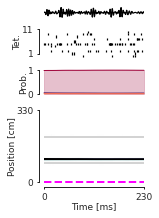

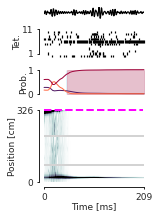

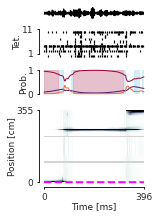

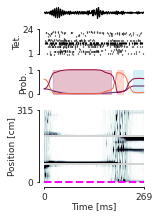

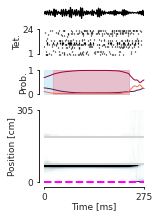

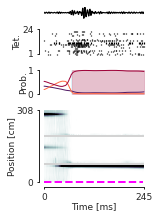

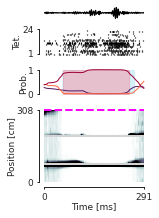

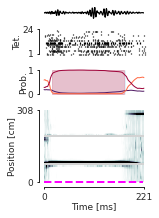

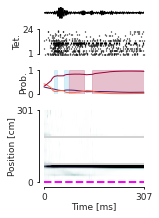

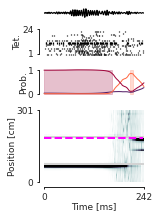

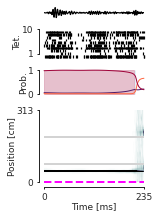

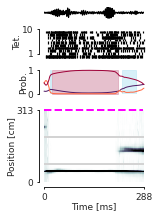

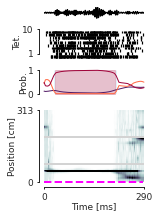

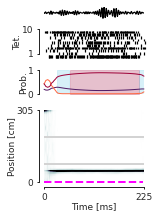

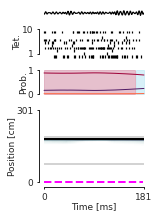

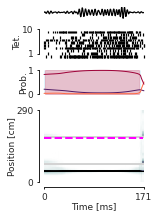

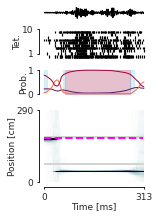

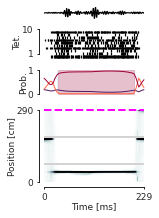

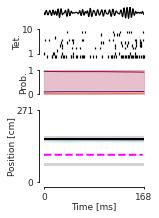

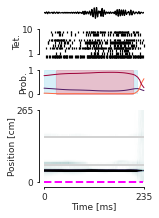

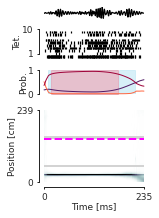

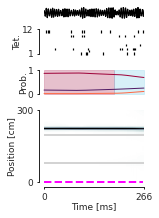

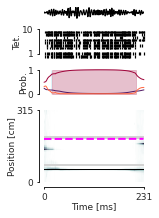

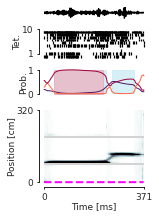

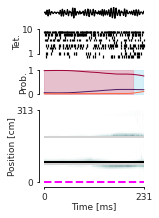

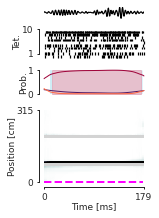

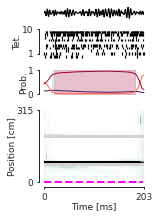

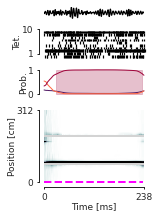

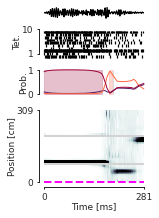

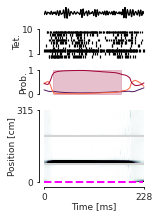

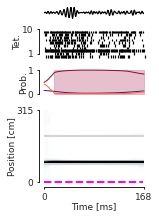

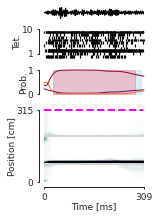

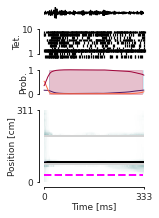

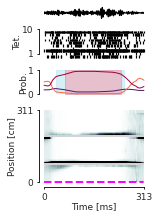

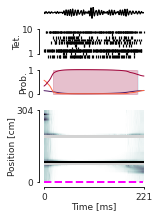

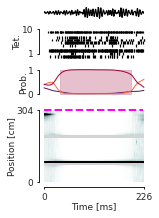

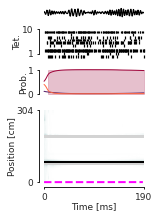

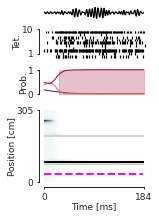

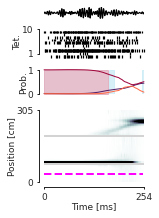

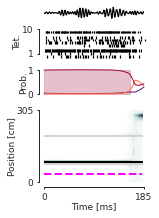

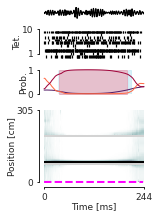

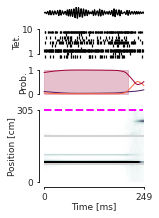

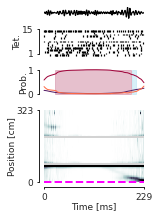

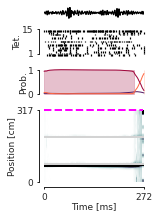

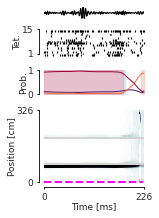

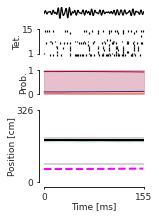

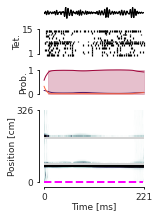

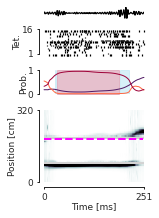

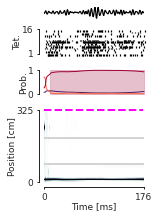

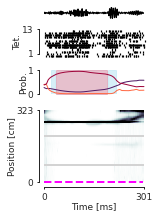

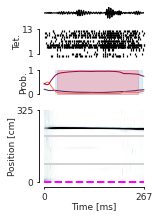

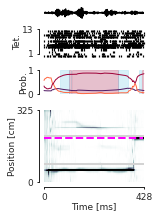

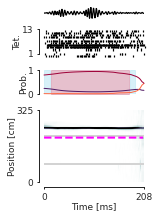

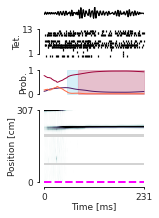

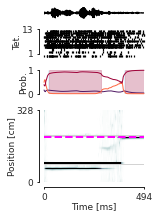

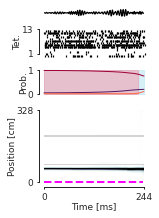

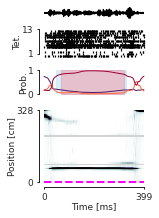

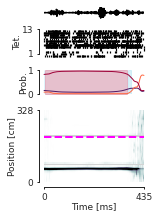

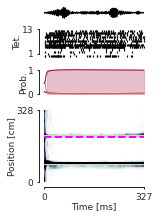

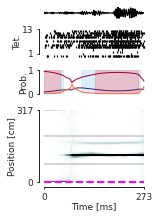

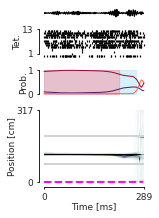

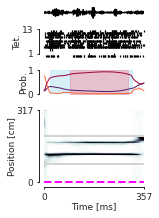

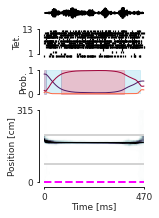

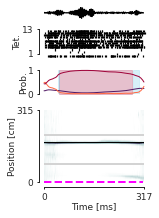

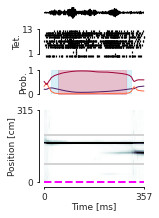

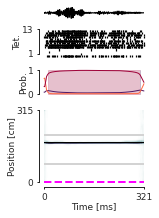

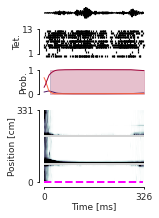

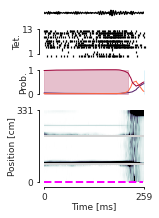

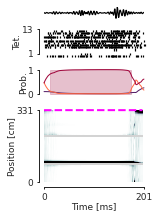

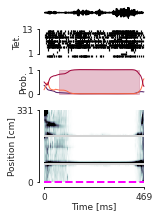

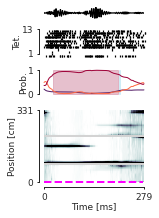

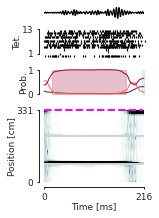

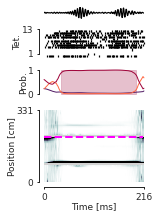

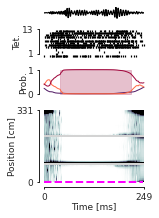

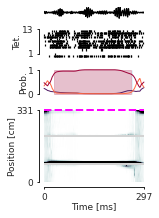

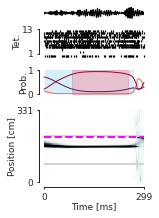

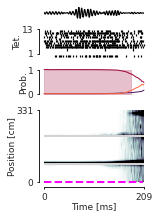

In [12]:
for epoch_key, df in non_local_hover.groupby(["Animal ID", "day", "epoch"]):
    print(epoch_key)
    plot_ripple_figure_1D(
        epoch_key,
        df.reset_index().ripple_number.values,
        is_save_figure=False,
        cmap="bone_r",
        make_movie=False,
    )

In [18]:
non_local_hover.iloc[np.asarray([5, 16, 25, 26, 27, 44, 49, 51, 53, 56, 69]) - 1].index

MultiIndex([('bon',  7, 2, 105),
            ('dav',  4, 6,  21),
            ('egy',  7, 4, 108),
            ('egy',  7, 6,  92),
            ('egy',  7, 6, 115),
            ('fra',  4, 4, 151),
            ('fra',  8, 2,  60),
            ('gov', 10, 6,  10),
            ('gov', 10, 6,  19),
            ('gov', 12, 6,  21),
            ('gov', 13, 6,  12)],
           names=['Animal ID', 'day', 'epoch', 'ripple_number'])

In [ ]:
('fra',  4, 4, 151), ('gov', 13, 6,  12)